# 2D 1 Comp GMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy.stats import norm
import corner as corner

In [2]:
%matplotlib notebook

### Data simulation

<IPython.core.display.Javascript object>


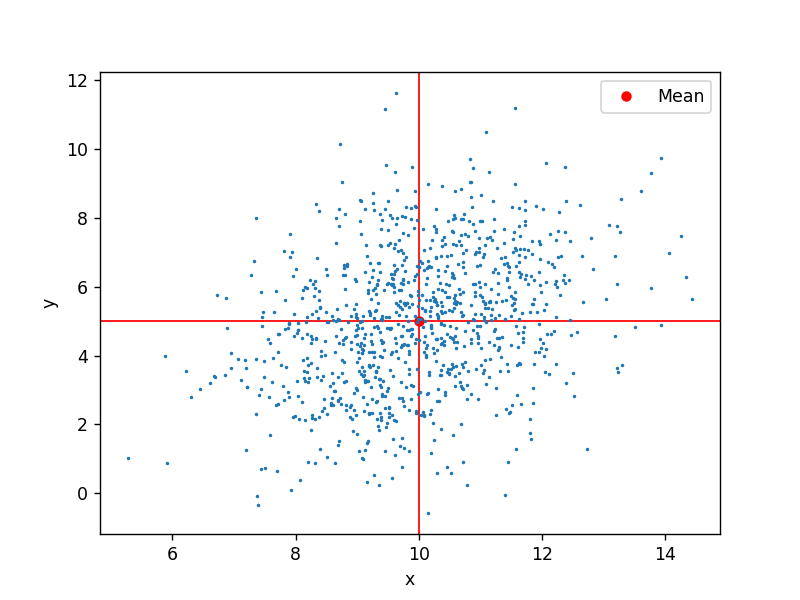

<IPython.core.display.Javascript object>


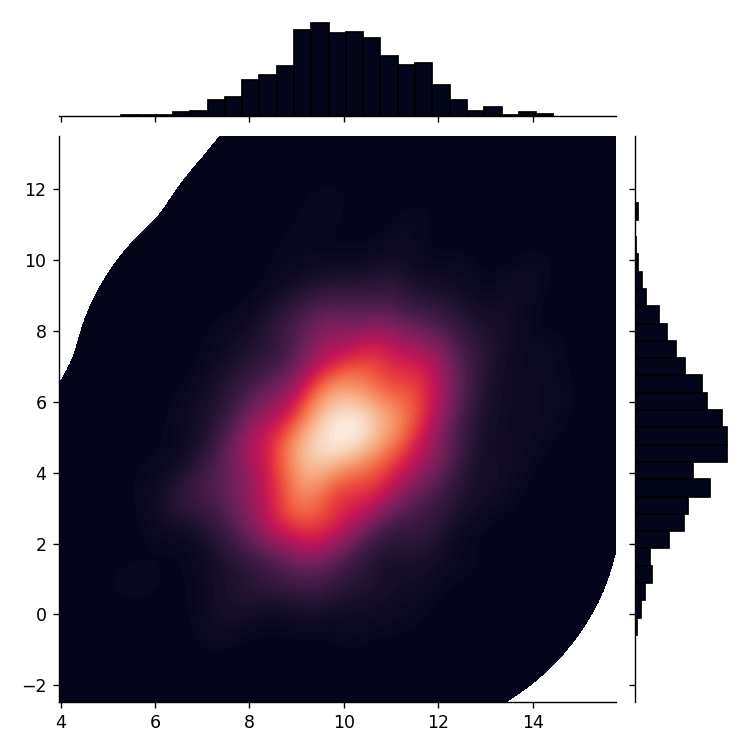

In [32]:
set_seed = True
if set_seed:
    np.random.seed(923114)

N = 1000
μ = [10, 5]
σ = [2, 4]
cov = 1
Σ = np.array([[σ[0]**2, cov], [cov, σ[1]**2]])

data = multivariate_normal.rvs(mean=μ, cov=Σ, size=N)
x = data[:,0]
y = data[:,1]

plt.figure()
ax = plt.gca()
ax.plot(μ[0], μ[1], 'r.', markersize=10, label='Mean')
ax.axvline(μ[0], color='r', linewidth=1)
ax.axhline(μ[1], color='r', linewidth=1)
ax.plot(x, y, '.', markersize=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

g = sns.JointGrid(x=x, y=y)
g.plot_joint(sns.kdeplot,
             fill=True,
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

In [4]:
def model(x, p):
    #Insert stuff
    return p

#Cholesky lower triangular matrix
def CholeskyLTM(lem):
    L = np.matrix([[np.exp(lem[0]), 0], [lem[1], np.exp(lem[2])]])
    cov = L*L.T
    return cov

def inverseCholeskyLTM(cov):
    L = np.linalg.cholesky(cov)
    lem_0 = np.log(L[0, 0])
    lem_1 = L[1, 0] / np.exp(lem_0)
    lem_2 = np.log(L[1, 1]) - lem_1**2
    return np.array([lem_0, lem_1, lem_2])

def log_likelihood(p, x, prior_check=1):
    p = model(x, p)
    μ = p[:2]
    lem = p[2:]
    Σ = CholeskyLTM(lem)
    logl = multivariate_normal.logpdf(x, mean=μ, cov=Σ)
    total = np.sum(logl)*prior_check
    return total

In [5]:
from dynesty import NestedSampler

ndim = 5

def unit_transform(u, centre, span):
    return 2*span*u + centre-span

def prior_transform(u):
    x = np.array(u)
    
    x[0] = norm.ppf(x[0], 10, 4)
    x[1] = norm.ppf(x[1], 5, 2)
    x[3] = unit_transform(x[3], 0, 0.5)
    return x

sampler = NestedSampler(log_likelihood, prior_transform, ndim, logl_args=[data], nlive=2000)
sampler.run_nested()

z = sampler.results
results = z.samples_equal()

29249it [01:27, 335.14it/s, +2000 | bound: 21 | nc: 1 | ncall: 137579 | eff(%): 23.049 | loglstar:   -inf < -3839.261 <    inf | logz: -3854.798 +/-  0.112 | dlogz:  0.001 >  2.009]


In [6]:
for p in results:
    cov = CholeskyLTM(p[2:])
    σ0, σ1, σ01 = cov[0, 0], cov[1, 1], cov[0, 1]
    p[2:] = [σ0, σ1, σ01]

<IPython.core.display.Javascript object>


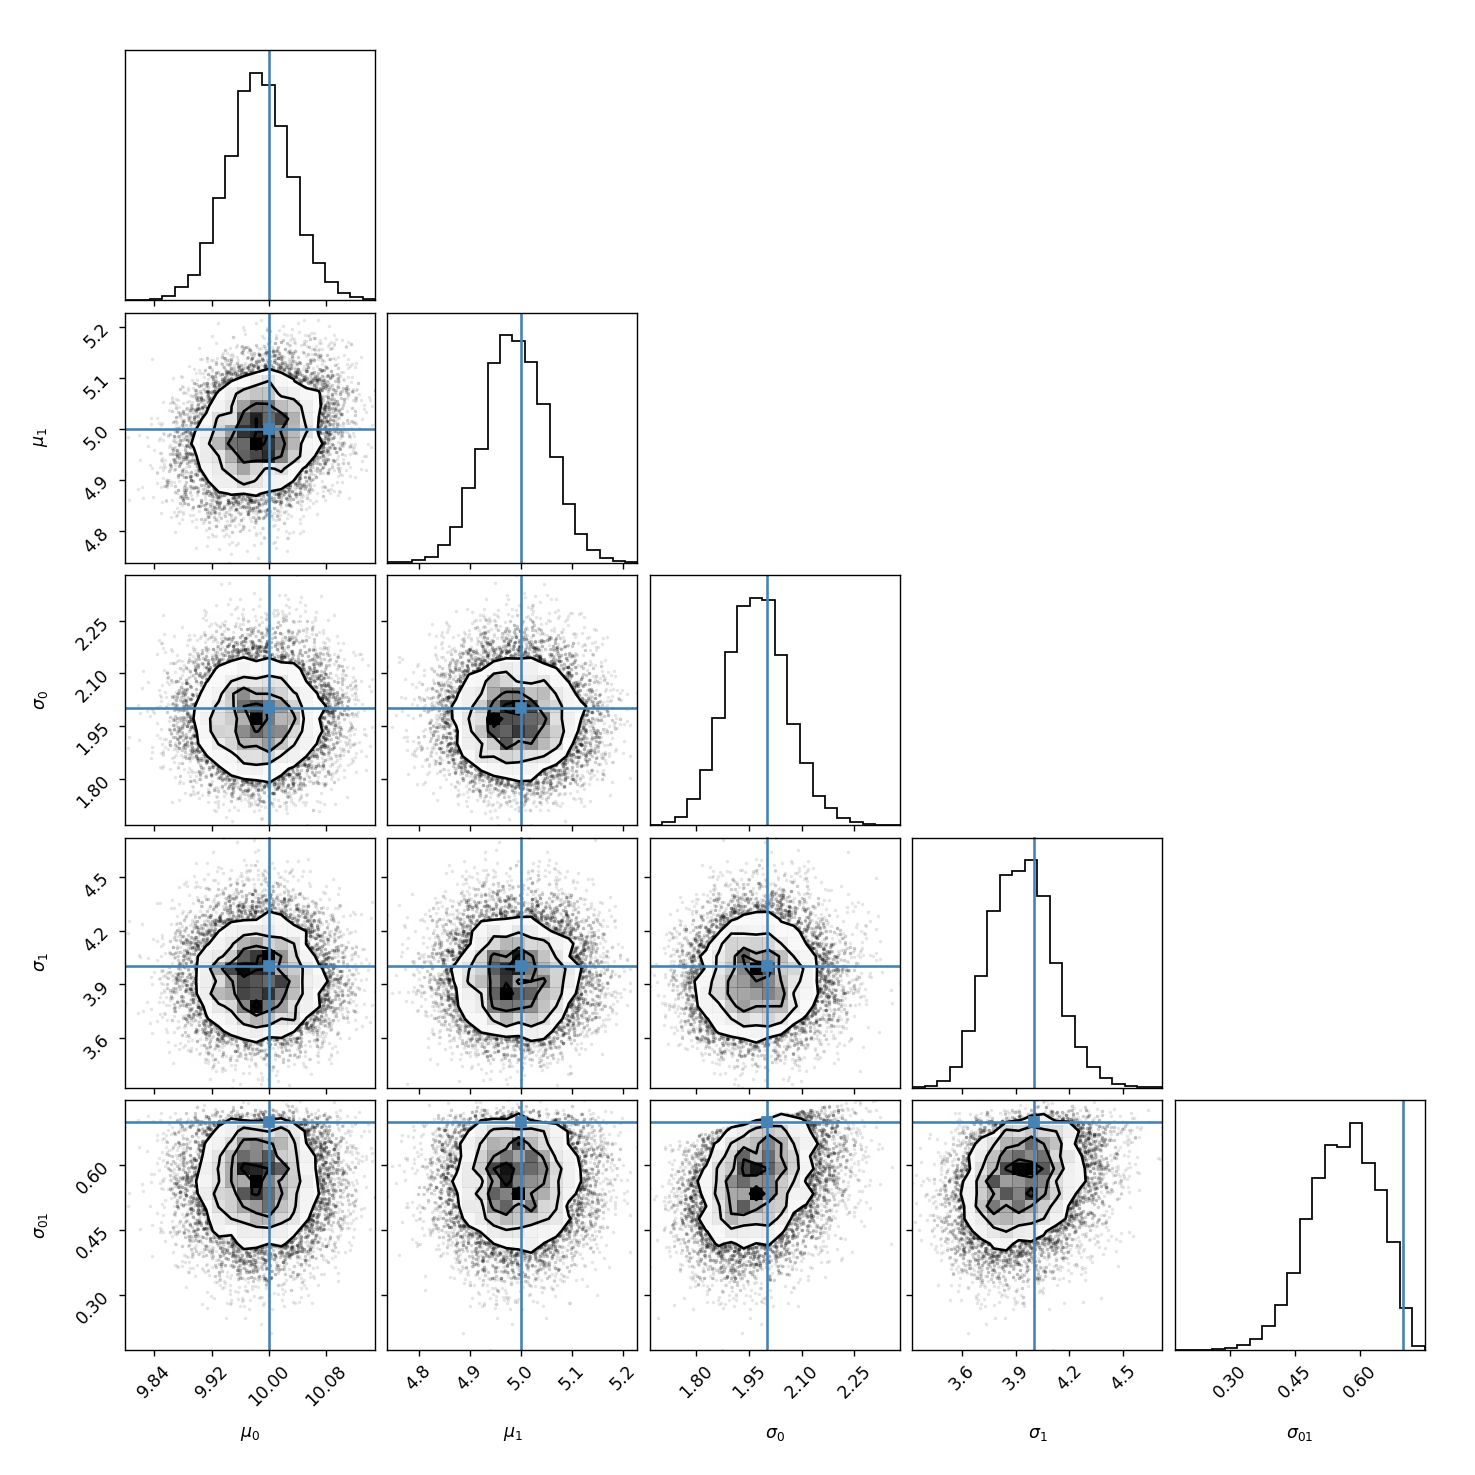

In [7]:
corner.corner(results, labels=[r'$μ_0$', r'$μ_1$', r'$σ_0$', r'$σ_1$', r'$σ_{01}$'], truths=[μ[0], μ[1], Σ[0, 0], Σ[1, 1], Σ[0, 1]]);